In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from preprocessing import my_plot, analysis, generate_mean_std, SPCRules, rearange_spc_labels

def txt2csv(filename, durations: list, labels: list, save_csv: bool = True, save_dir: str = "./csv"): # filename: *.txt
    # read txt as dataframe
    df = pd.read_csv(filename, sep = '	', header=None)
    df.drop(columns = [0], inplace = True)
    columns = [
        "P51_05", "P51_06", "T51_01", "F51_01", "LC51_03CV", # Actuator01
        "LC51_03X", "LC51_03PV", "TC51_05", "T51_08", "D51_01",
        "D51_02", "F51_02", "PC51_01", "T51_06", "P51_03", "T51_07",
        "P57_03", "P57_04", "T57_03", "FC57_03PV", "FC57_03CV", "FC57_03X", # Actuator02
        "P74_00", "P74_01", "T74_00", "F74_00", "LC74_20CV", "LC74_20X", # Actuator03
        "LC74_20PV", "F74_30", "P74_30", "T74_30"
    ]
    df.columns = columns
    
    # set class label
    class_label = np.zeros((df.shape[0],), dtype = "int8")
    for duration, label in zip(durations, labels):
        class_label[duration[0]: duration[1]] = label

    anomaly_label = np.asarray((class_label != 0), dtype = "int8")
    
#     df['fault_label'] = class_label
    df['anomaly_label'] = anomaly_label
    
    if save_csv:
        file = filename.split('/')[-1].split('.')[0] + ".csv"
        save_dir += '/'
        df.to_csv(save_dir + file, index = False)
        
    return df

## Data Flow of Preprocessing
Raw data -> Feature Selection -> Generate mean & std -> Generate spc labels -> Re-arange spc labels -> Done

In [6]:
# Generate raw data in csv format
file = "./raw/30102001.txt"
durations = [
    (58800, 59800),
    (57340, 57890)
]
labels = [18, 18]
df = txt2csv(file, durations, labels)

file = "./raw/09112001.txt"
durations = [
    (57275, 57550),
    (58520, 58625),
    (58830, 59300),
    (60650, 60700),
    (60870, 60960)
]
labels = [16, 18, 18, 16, 16]
df = txt2csv(file, durations, labels)

file = "./raw/17112001.txt"
durations = [
    (54600, 54700),
    (56670, 56770),
    (53780, 53794),
    (54193, 54215),
    (55482, 55517),
    (55977, 56015),
    (57030, 57072),
    (57475, 57530),
    (57675, 57800),
    (58150, 58325),
]
labels = [18, 16, 17, 17, 19, 19, 19, 16, 16, 19]
df = txt2csv(file, durations, labels)

file = "./raw/20112001.txt"
durations = [
    (37780, 38400),
    (44400, None),
]
labels = [17, 17]
df = txt2csv(file, durations, labels)

## Feature Selection & Generate mean, std

In [8]:
# Choose 15 features in spc description
target_features = [
    "LC51_03CV", "LC51_03X", "LC51_03PV",
    "P51_06", "T51_01", "F51_01",
    "P57_03", "P57_04", 
    "FC57_03PV", "FC57_03CV", "FC57_03X",
    "F74_00", "LC74_20CV", "LC74_20X",
    "LC74_20PV", 
]
label_features = ["anomaly_label"]
wnd_size = 5000

filelst = ["30102001", "09112001", "17112001", "20112001"]
# filelst = ["30102001_user_anomaly"]
for file in filelst:
    filename = f"./csv/{file}.csv"
    df = pd.read_csv(filename)
    df_fe = generate_mean_std(df, target_features, label_features, wnd_size)
    df_fe.to_csv(f"./csv_fe/{file}.csv", index = False)

## Generate spc labels & Rearange spc labels

In [ ]:
# filter dummy spc labels
#     Watch proportion about spc labels
rule_df = df_fe.iloc[:, 15:]
remove_cols = []
for i, item in enumerate(rule_df.sum(axis = 0)):
    rate = item / rule_df.shape[0] * 100
    if rate > 40:
        print(f"{rule_df.columns[i]}: {rate:.2f}%")
        remove_cols.append(rule_df.columns[i])
        
print(len(remove_cols))
print(remove_cols)


def print_rule(rule):
    print(rule.shape)
    print(np.sum(rule.to_numpy(), axis=(1, 0)))
    print()
    
print_rule(rule1_out)
print_rule(rule2_out)
print_rule(rule5_out)
print_rule(rule6_out)
print_rule(rule7_out)
print_rule(rule8_out)

In [44]:
# Generate spc labels and remove dummy anomalies
csv_lst = ["09112001", "17112001", "20112001", "30102001"]
# csv_lst = ["30102001_user_anomaly"]
for filename in csv_lst:
    df = pd.read_csv(f"csv_fe/{filename}.csv")
    features_num = 15
    features_name = df.columns[:features_num]
    datas = df.iloc[:, :features_num]
    datas.columns = ["" for _ in range(datas.shape[1])]
    means = df.iloc[:, features_num: 2 * features_num]
    means.columns = ["" for _ in range(means.shape[1])]
    stds = df.iloc[:, 2 * features_num: 3 * features_num]
    stds.columns = ["" for _ in range(stds.shape[1])]

    rule_gen = SPCRules(datas, means, stds)
    rule_lst = []
    for i in range(1, 7):
        rule_df = rule_gen.detect(idx = i)
        columns = [f"{name}_rule{i}" for name in features_name]
        rule_df.columns = columns
        rule_lst.append(rule_df)
    
    df_fe = pd.concat([df[features_name]] + rule_lst, axis = 1)
    df_fe['anomaly_label'] = df['anomaly_label']
    # remove dummy rule columns
    remove_cols = ['LC51_03CV_rule2', 'LC51_03X_rule2', 'P51_06_rule2', 'T51_01_rule2', 'F51_01_rule2', 'P57_03_rule2', 'FC57_03PV_rule2', 'FC57_03CV_rule2', 'FC57_03X_rule2', 'T51_01_rule4', 'P57_03_rule4', 'FC57_03PV_rule4', 'FC57_03CV_rule4', 'FC57_03X_rule4', 'T51_01_rule5', 'T51_01_rule6', 'FC57_03PV_rule6']
    df_fe.drop(columns = remove_cols, inplace = True)
    # rearange columns to fit SPCPatchBert input
    spc_labels_lst = df_fe.columns[features_num: -1]
    df_rearange, spc_head_lst = rearange_spc_labels(df_fe, list(features_name), list(spc_labels_lst), ['anomaly_label'])
    df_fe.to_csv(f"csv_fe/{filename}_spc_label.csv", index = False)

## Generate some patterns which users add

(250,) (250,) (250,)


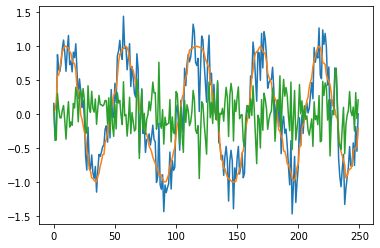

In [9]:
import timesynth as ts
# Initializing TimeSampler
time_sampler = ts.TimeSampler(stop_time=20)
# Sampling irregular time samples
irregular_time_samples = time_sampler.sample_irregular_time(num_points=500, keep_percentage=50)
# Initializing Sinusoidal signal
sinusoid = ts.signals.Sinusoidal(frequency=0.25)
# Initializing Gaussian noise
white_noise = ts.noise.GaussianNoise(std=0.3)
# Initializing TimeSeries class with the signal and noise objects
timeseries = ts.TimeSeries(sinusoid, noise_generator=white_noise)
# Sampling using the irregular time samples
samples, signals, errors = timeseries.sample(irregular_time_samples)
print(samples.shape, signals.shape, errors.shape)
plt.plot(samples)
plt.plot(signals)
plt.plot(errors)

## EDA

In [ ]:
filename = "./csv/20112001.csv"
df = pd.read_csv(filename)
df.head()

In [ ]:
# fault in 30102001.csv
file = "./csv/30102001.csv"
start, end = 58500, 60500
col_lst = ["LC51_03CV", "LC51_03X", "LC51_03PV"]
analysis(file, start, end, col_lst)



start, end = 57340, 57890
col_lst = ["F74_00", "LC74_20CV", "LC74_20X", "LC74_20PV"]
analysis(file, start, end, col_lst)

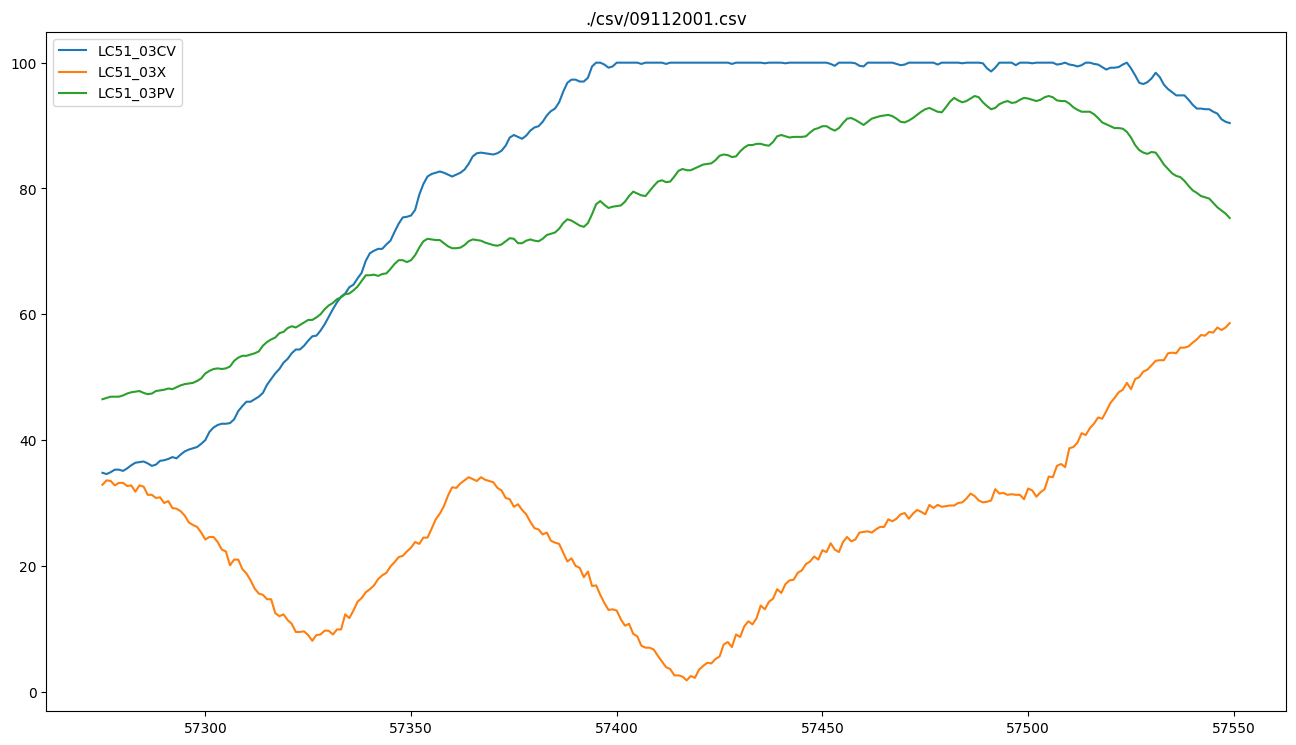

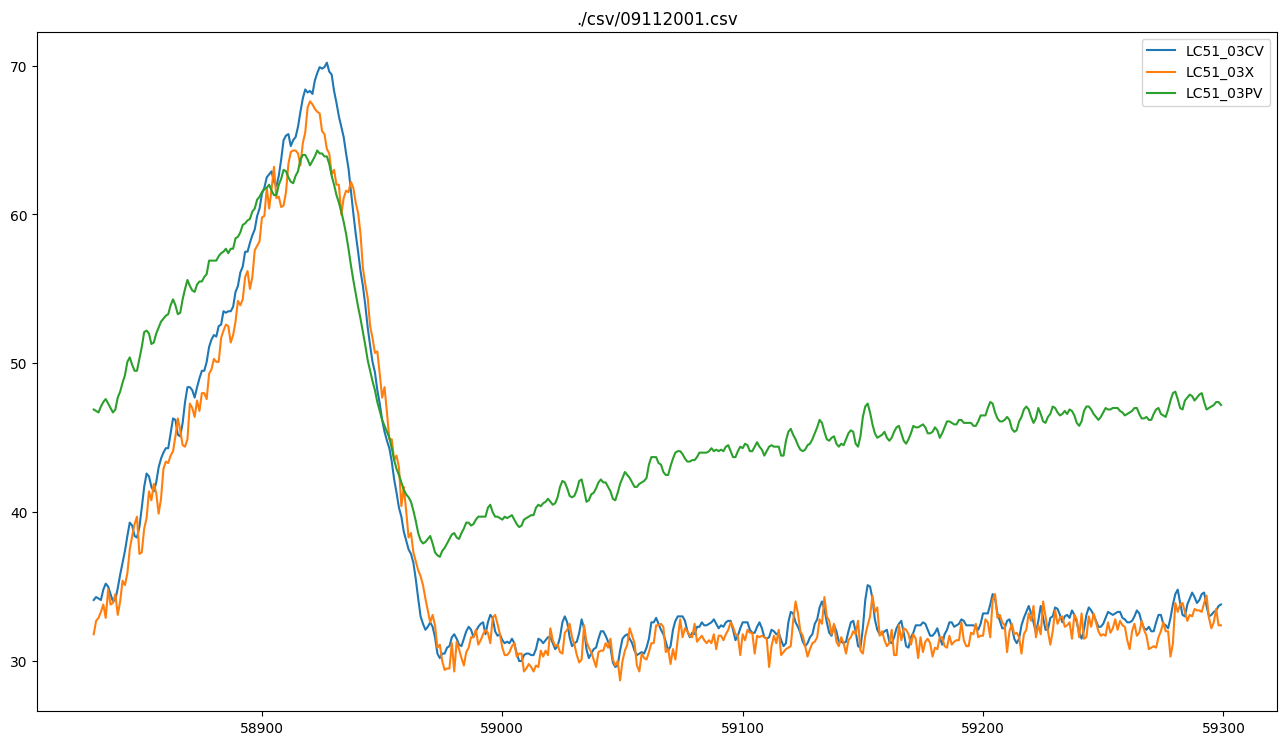

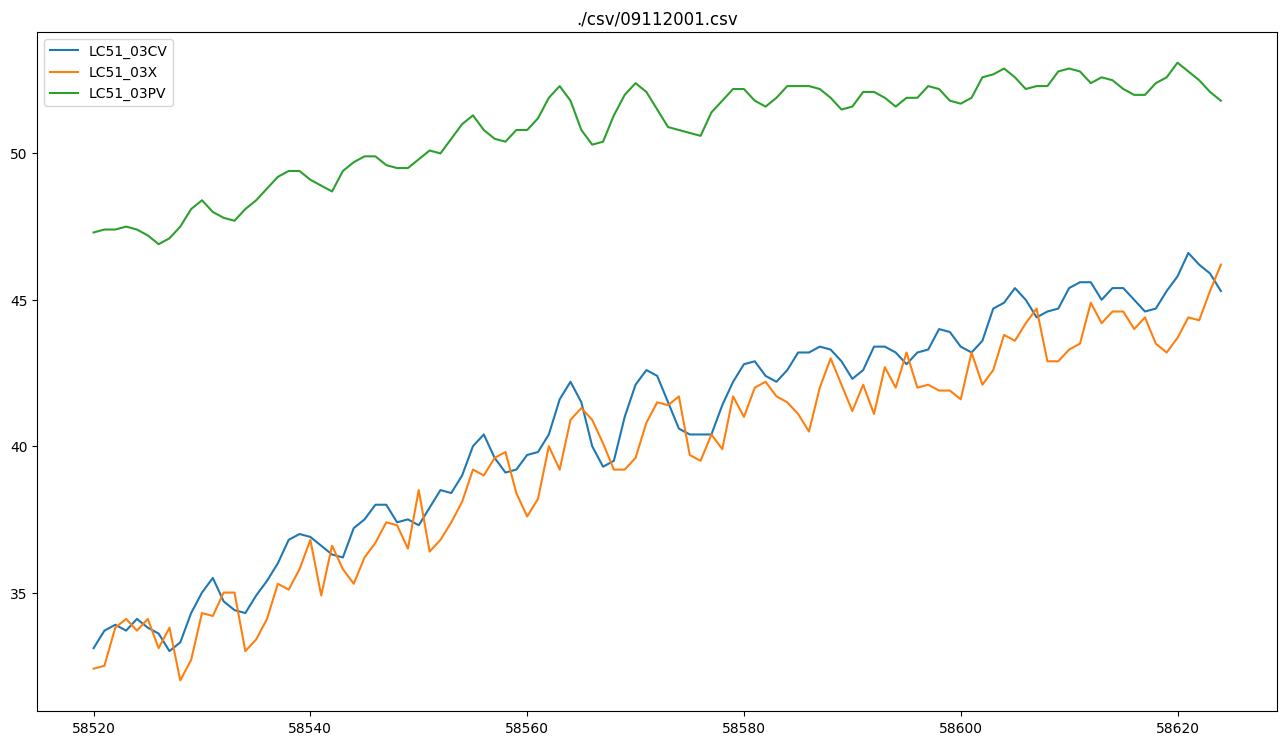

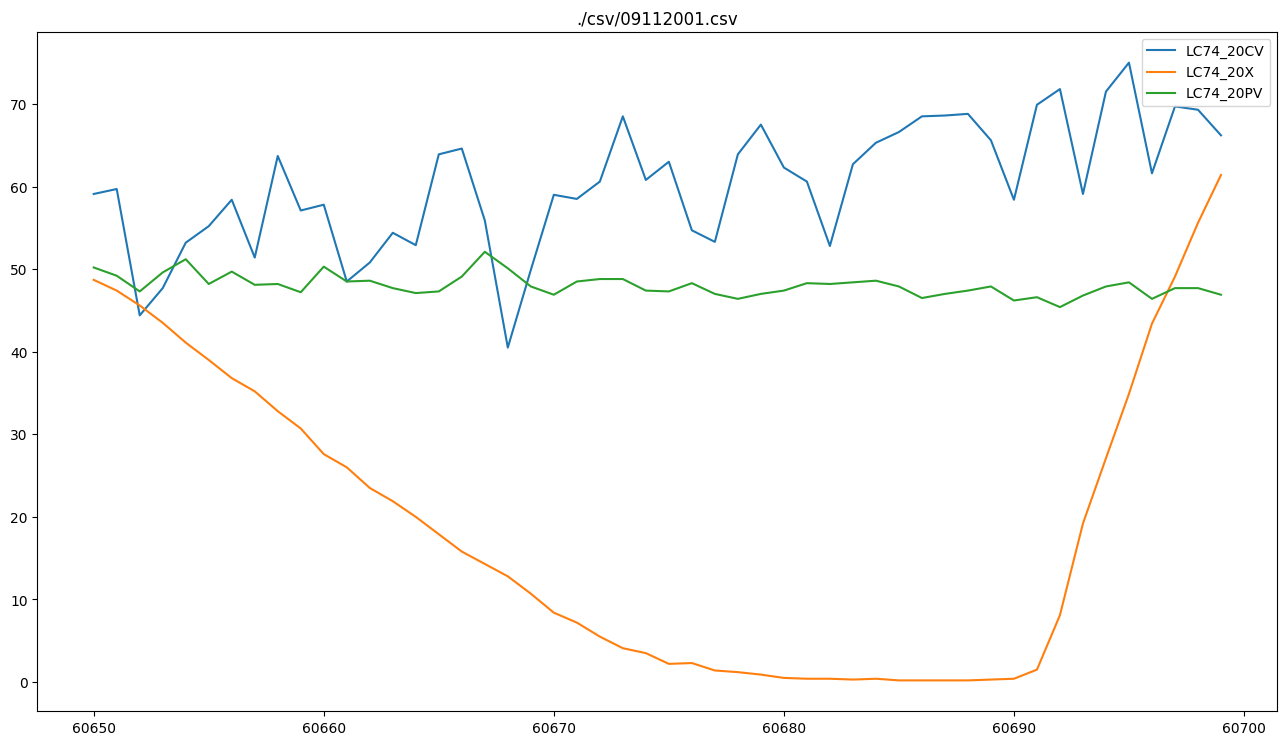

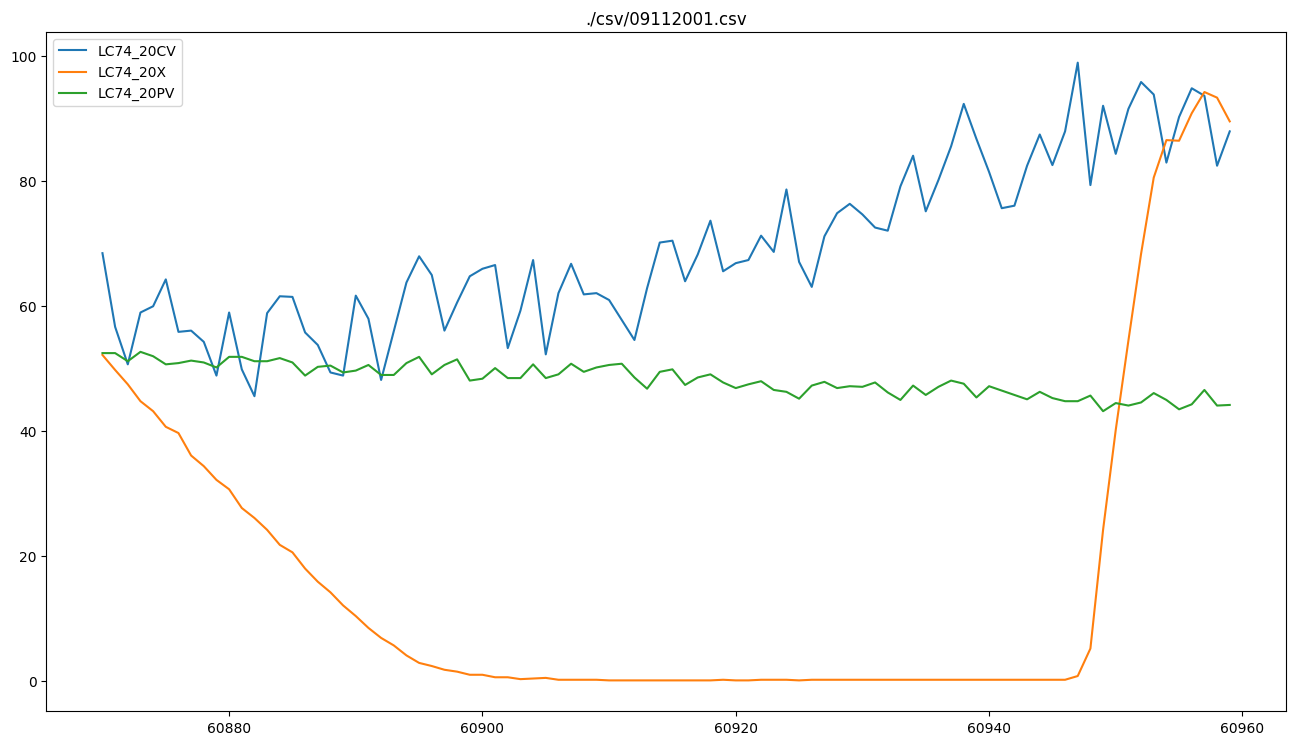

In [4]:
# fault in 09112001.csv
file = "./csv/09112001.csv"
start, end = 57275, 57550
col_lst = ["LC51_03CV", "LC51_03X", "LC51_03PV"]
analysis(file, start, end, col_lst)

start, end = 58830, 59300
analysis(file, start, end, col_lst)

start, end = 58520, 58625
analysis(file, start, end, col_lst)

start, end = 60650, 60700
col_lst = ["LC74_20CV", "LC74_20X", "LC74_20PV"]
analysis(file, start, end, col_lst)

start, end = 60870, 60960
analysis(file, start, end, col_lst)

In [ ]:
# fault in 171122001.csv
start, end = 54600, 54700
file = "./csv/17112001.csv"
col_lst = ["LC51_03CV", "LC51_03X", "LC51_03PV"]
analysis(file, start, end, col_lst)

start, end = 3000, 3500
col_lst = [
    "P51_05", "P51_06", "LC51_03CV", # Actuator01
    "FC57_03CV", "FC57_03X", # Actuator02
    "P74_00", "P74_01", 
]
analysis(file, start, end, col_lst)

# start, end = 56670, 56770
# analysis(file, start, end, col_lst)

# start, end = 37780, 58400
# col_lst = ["P51_06", "T51_01", "F51_01"]
# analysis(file, start, end, col_lst)



## Test TSAnomalyDataset

In [ ]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../../")
from ts_transformers.data import TSAnomalyDataset, TSAnomalyConfig
from ts_transformers.data import SPCAnomalyDataset, SPCAnomalyConfig

In [ ]:
# test TSAnomalyDataset (base dataset)
config = TSAnomalyConfig(
    target_col="anomaly_label",
    window_size=256,
)

filepath = "./csv/17112001.csv"
df = pd.read_csv(filepath)
ts_dataset = TSAnomalyDataset(df, config)

x, y = ts_dataset[0]
print(x.shape, y.shape)

# test SPCDataset (derived class)
config = SPCAnomalyConfig(
    spc_col="fault_label",
    target_col="anomaly_label",
    window_size=256,
)
spc_dataset = SPCAnomalyDataset(df, config)

x, spc, y = spc_dataset[0]
print(x.shape, spc.shape, y.shape)

In [ ]:
target = '09112001.csv'
df = pd.read_csv(f'csv/{target}')
df

## Anomaly detection by machine learning method

In [ ]:
import pandas as pd
import numpy as np

# train: 09112001.csv
# test: 17112001.csv
train_file = "09112001.csv"
test_file = "17112001.csv"
train_df = pd.read_csv(f'csv/{train_file}')
test_df = pd.read_csv(f'csv/{test_file}')

drop_cols = [f"spc_label_{i:02}" for i in range(6)] + ["fault_label", "anomaly_label"]
y_train = np.array(train_df["anomaly_label"])
x_train = np.array(train_df.drop(columns = drop_cols))
y_test = np.array(test_df["anomaly_label"])
x_test = np.array(test_df.drop(columns = drop_cols))

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

In [ ]:
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

IF = IsolationForest(
    n_estimators=70,
    max_features=0.8,
    contamination=0.3#706/86400
)
IF.fit(x_train)
pred = IF.predict(x_test)
pred[pred == -1] = 0
result = classification_report(y_test, pred)
print(result)

# RF = RandomForestClassifier(class_weight = "balanced")
# RF.fit(x_train, y_train)
# pred = RF.predict(x_train)
# result = classification_report(y_train, pred)
# print(result)

# pred = RF.predict(x_test)
# result = classification_report(y_test, pred)
# print(result)

In [ ]:
OCS = OneClassSVM()
OCS.fit(x_train)
pred = OCS.predict(x_test)
pred[pred == -1] = 0
result = classification_report(y_test, pred)
print(result)

## Data synthesis

In [5]:
# re-arange the dataframe to fit the input of SPCPatchBert
target = "09112001"
features_num = 15
df = pd.read_csv(f"csv_fe/{target}_spc_label.csv")
features = df.columns[: features_num]

Index(['LC51_03CV', 'LC51_03X', 'LC51_03PV', 'P51_06', 'T51_01', 'F51_01',
       'P57_03', 'P57_04', 'FC57_03PV', 'FC57_03CV', 'FC57_03X', 'F74_00',
       'LC74_20CV', 'LC74_20X', 'LC74_20PV', 'LC51_03CV_rule1',
       'LC51_03X_rule1', 'LC51_03PV_rule1', 'P51_06_rule1', 'T51_01_rule1',
       'F51_01_rule1', 'P57_03_rule1', 'P57_04_rule1', 'FC57_03PV_rule1',
       'FC57_03CV_rule1', 'FC57_03X_rule1', 'F74_00_rule1', 'LC74_20CV_rule1',
       'LC74_20X_rule1', 'LC74_20PV_rule1', 'LC51_03PV_rule2', 'P57_04_rule2',
       'F74_00_rule2', 'LC74_20CV_rule2', 'LC74_20X_rule2', 'LC74_20PV_rule2',
       'LC51_03CV_rule3', 'LC51_03X_rule3', 'LC51_03PV_rule3', 'P51_06_rule3',
       'T51_01_rule3', 'F51_01_rule3', 'P57_03_rule3', 'P57_04_rule3',
       'FC57_03PV_rule3', 'FC57_03CV_rule3', 'FC57_03X_rule3', 'F74_00_rule3',
       'LC74_20CV_rule3', 'LC74_20X_rule3', 'LC74_20PV_rule3',
       'LC51_03CV_rule4', 'LC51_03X_rule4', 'LC51_03PV_rule4', 'P51_06_rule4',
       'F51_01_rule4', 'P57_

## Generate another anomaly pattern

In [3]:
import random

def my_plot(x, Ys, label_lst, title = "", figsize = (16, 9)):
    plt.figure(figsize = figsize, dpi = 100)
    plt.title(title)
    for y, label in zip(Ys, label_lst):
        plt.plot(x, y, label = label)
    plt.legend()
    plt.show()
    
def analysis(df, start: int, end: int, columns: list):
    Ys = df[columns][start: end].to_numpy().transpose()
    x = np.arange(start, end)
    my_plot(x, Ys, columns, file)
    
def generate_pattern(df, columns, start, end, pattern=0, interval=4):
    # single pattern
    data = df.copy()
    if pattern == 0:
        a_lowers = [70 for i in range(len(columns))]
        a_uppers = [80 for i in range(len(columns))]
        b_lowers = [20 for i in range(len(columns))]
        b_uppers = [30 for i in range(len(columns))]
        length = (end - start) // interval
        for i, col in enumerate(columns):
            lst = []
            for j in range(interval):
                if (i + j) % 2:
                    lower, upper = a_lowers[i], a_uppers[i]
                else:
                    lower, upper = b_lowers[i], b_uppers[i]
                lst.append(np.array([random.uniform(lower, upper) for _ in range(length)]))
            val = np.concatenate(lst)
            data[col][start: end] = val
    elif pattern == 1:
        means = df[columns].mean().to_numpy()
        stds = df[columns].std().to_numpy()
        a_lowers = means + 3 * stds
        a_uppers = means + 5 * stds
        b_lowers = means - 5 * stds
        b_uppers = means - 3 * stds
        length = (end - start) // interval
        for i, col in enumerate(columns):
            lst = []
            for j in range(interval):
                if (i + j) % 2:
                    lower, upper = a_lowers[i], a_uppers[i]
                else:
                    lower, upper = b_lowers[i], b_uppers[i]
                lst.append(np.array([random.uniform(lower, upper) for _ in range(length)]))
            val = np.concatenate(lst)
            data[col][start: end] = val
    return data

/tmp/ipykernel_148727/1928251111.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][start: end] = val
/tmp/ipykernel_148727/397718981.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["anomaly_label_user"][time[0]: time[1]] = 1


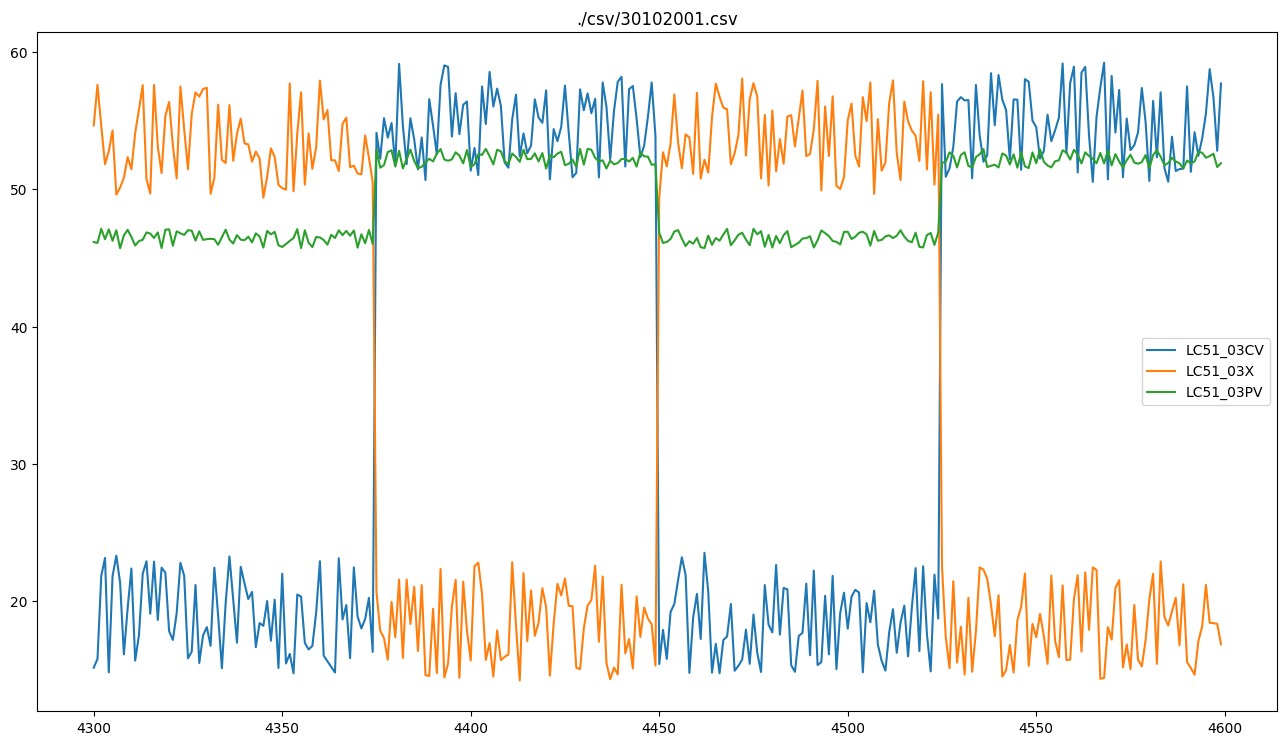

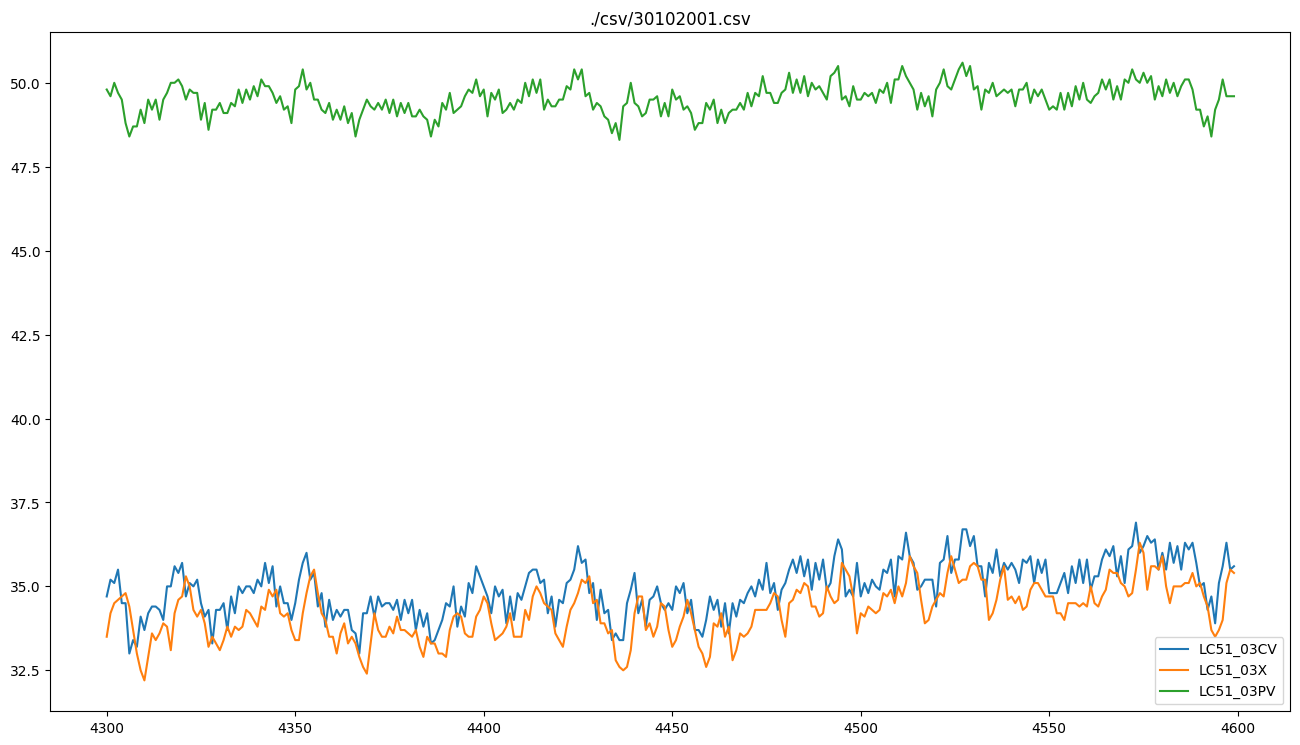

/tmp/ipykernel_148727/1928251111.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][start: end] = val
/tmp/ipykernel_148727/397718981.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["anomaly_label_user"][time[0]: time[1]] = 1


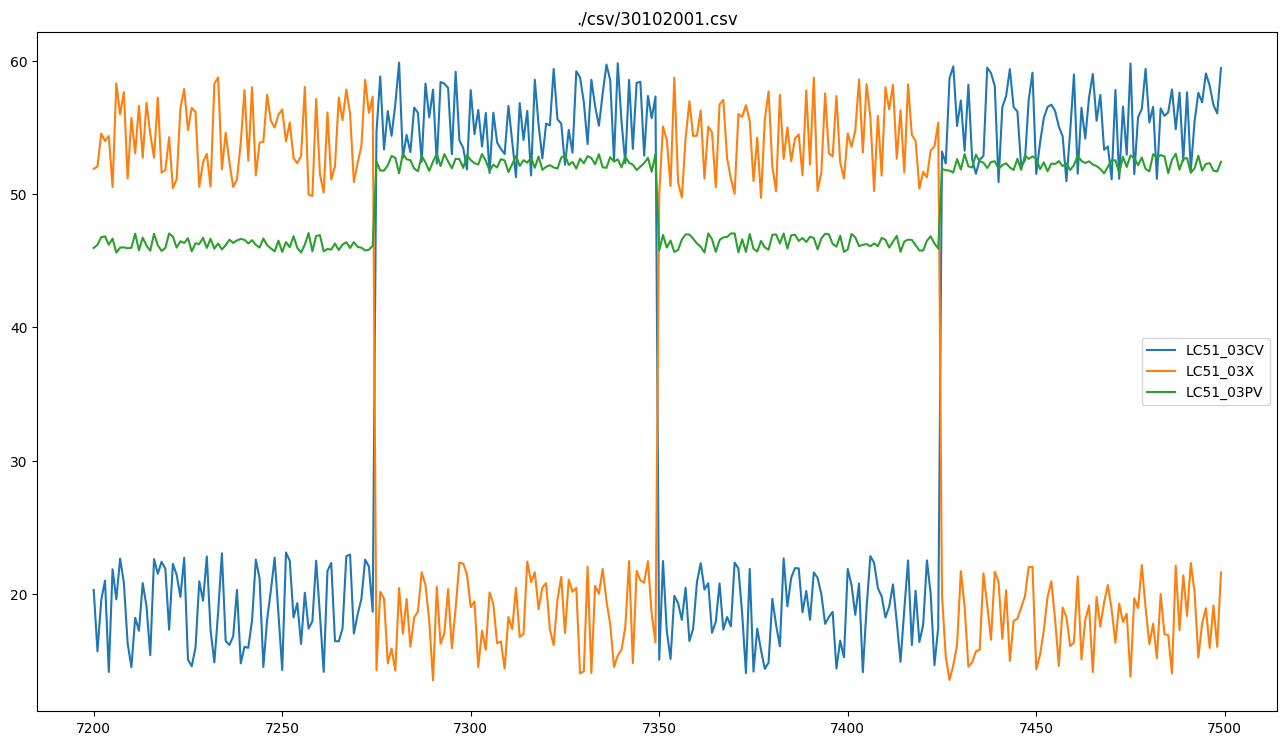

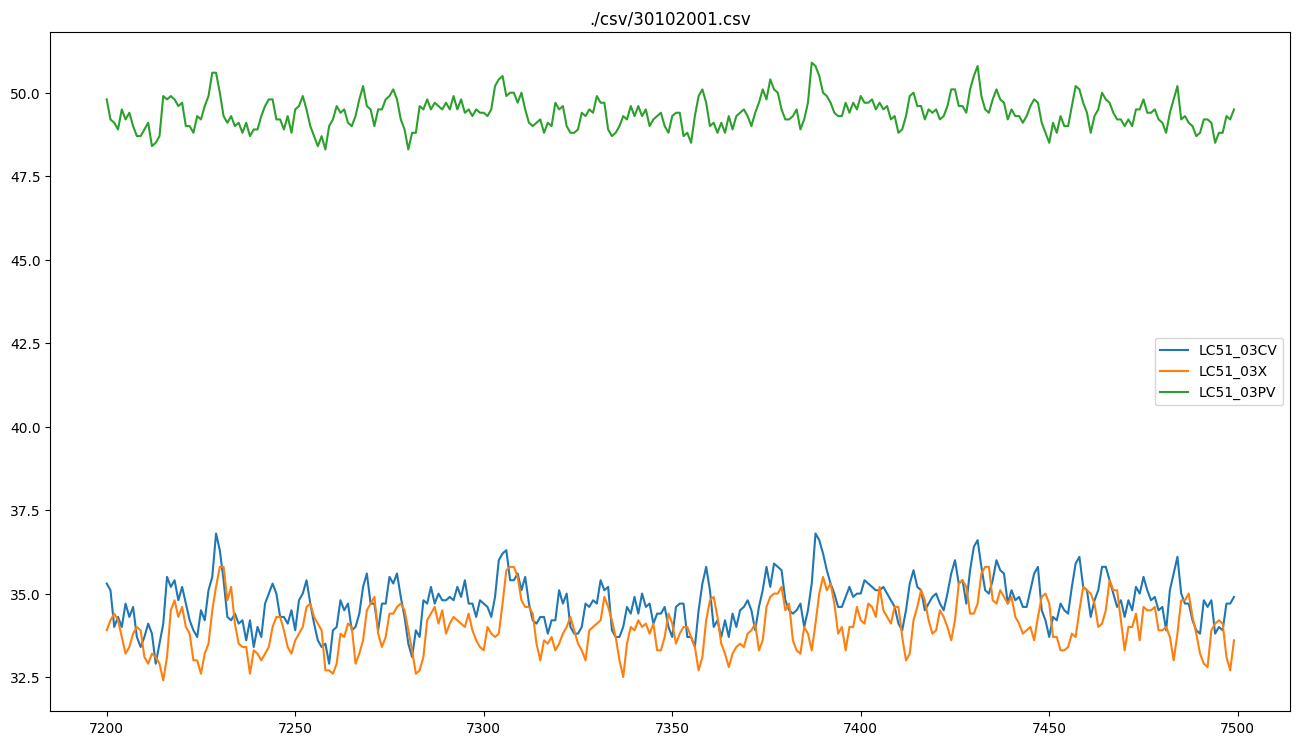

/tmp/ipykernel_148727/1928251111.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][start: end] = val
/tmp/ipykernel_148727/397718981.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["anomaly_label_user"][time[0]: time[1]] = 1


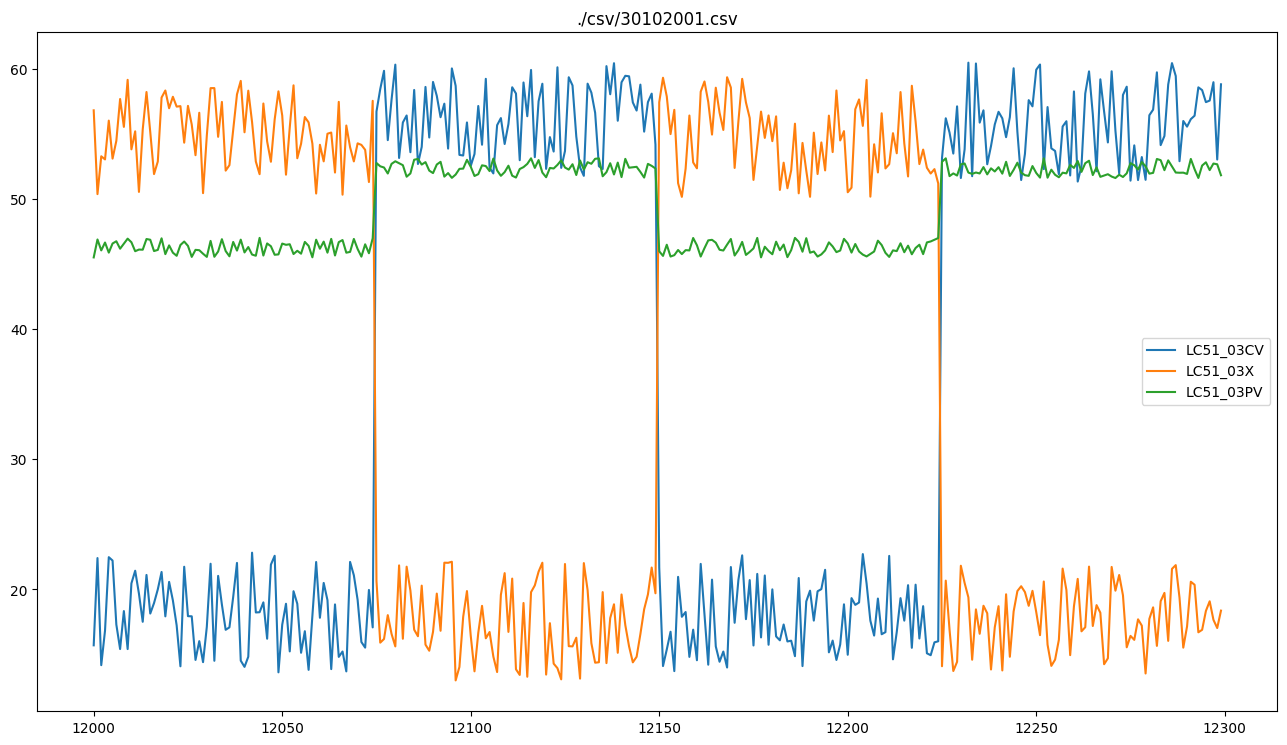

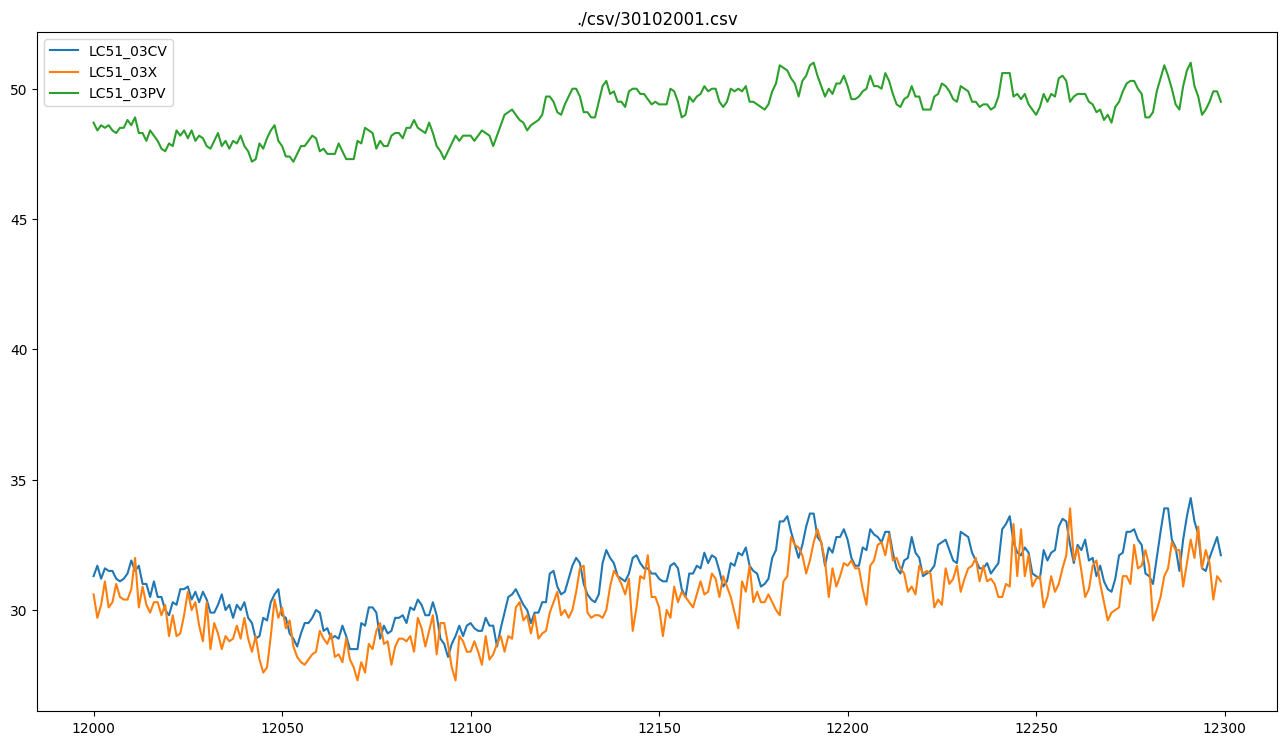

/tmp/ipykernel_148727/1928251111.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][start: end] = val
/tmp/ipykernel_148727/397718981.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["anomaly_label_user"][time[0]: time[1]] = 1


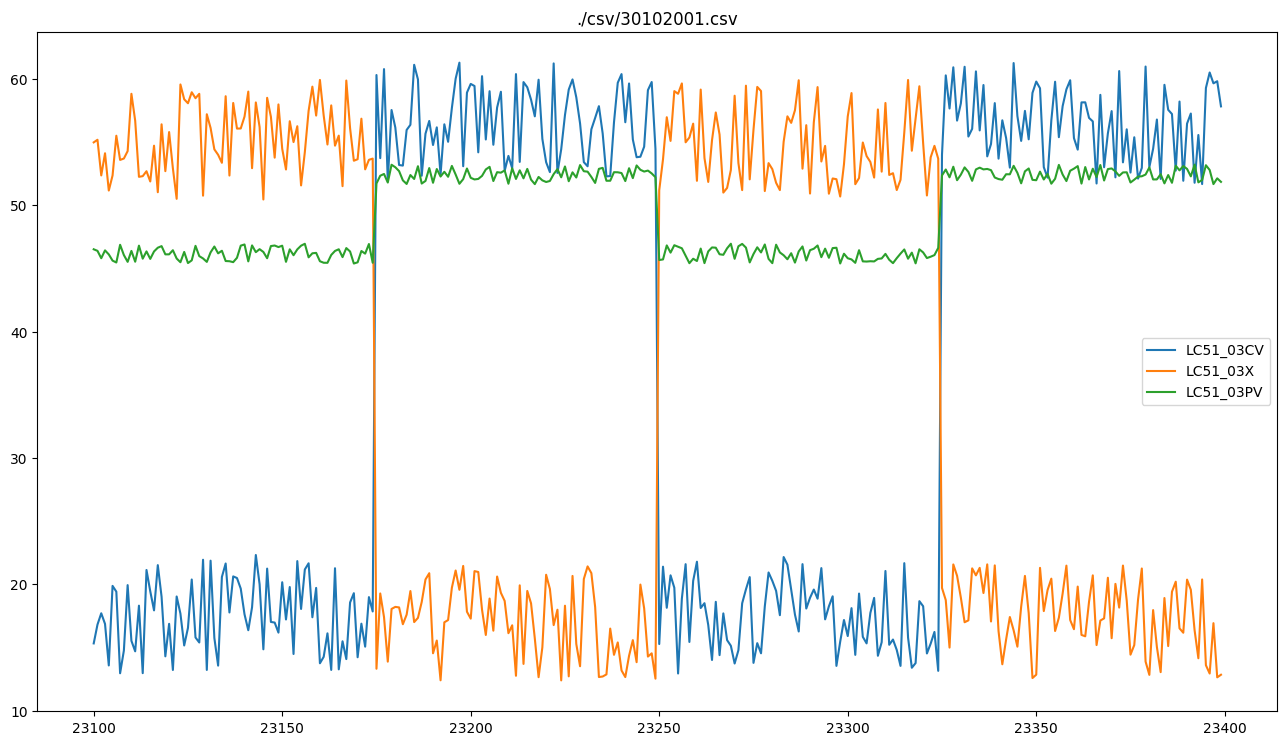

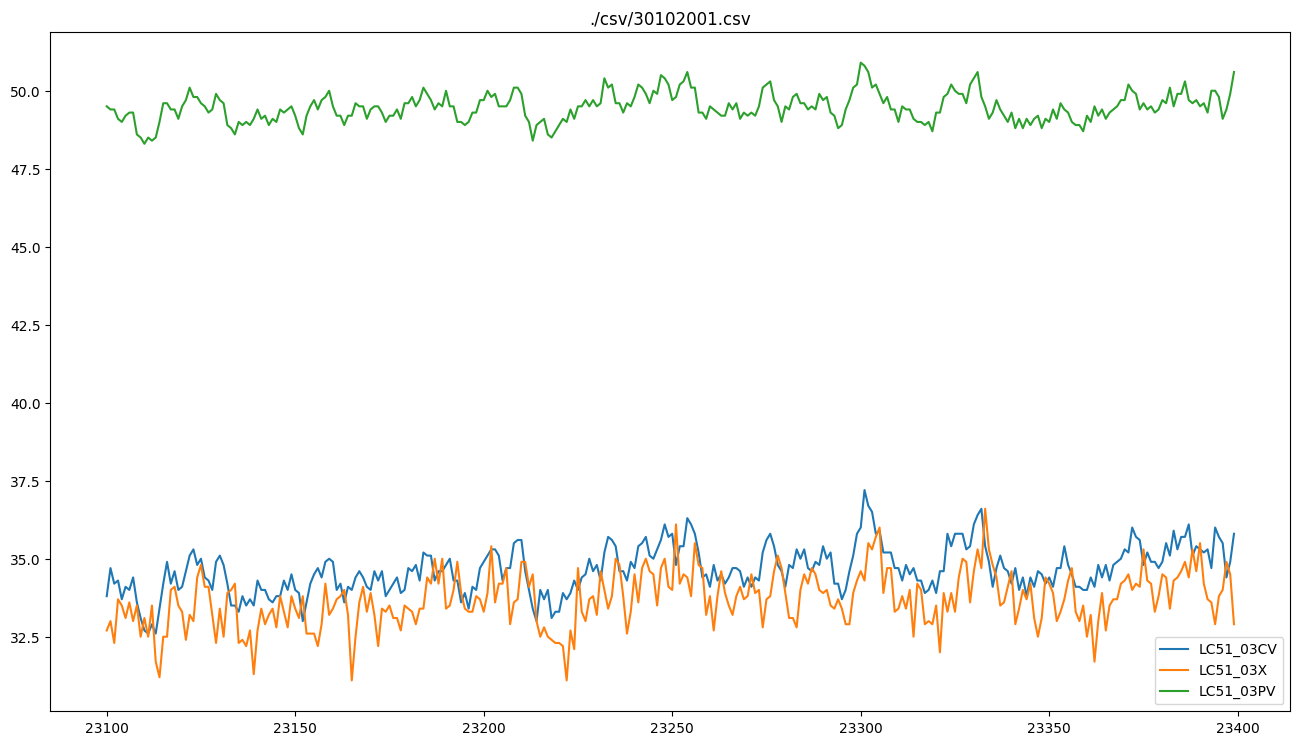

/tmp/ipykernel_148727/1928251111.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][start: end] = val
/tmp/ipykernel_148727/397718981.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["anomaly_label_user"][time[0]: time[1]] = 1


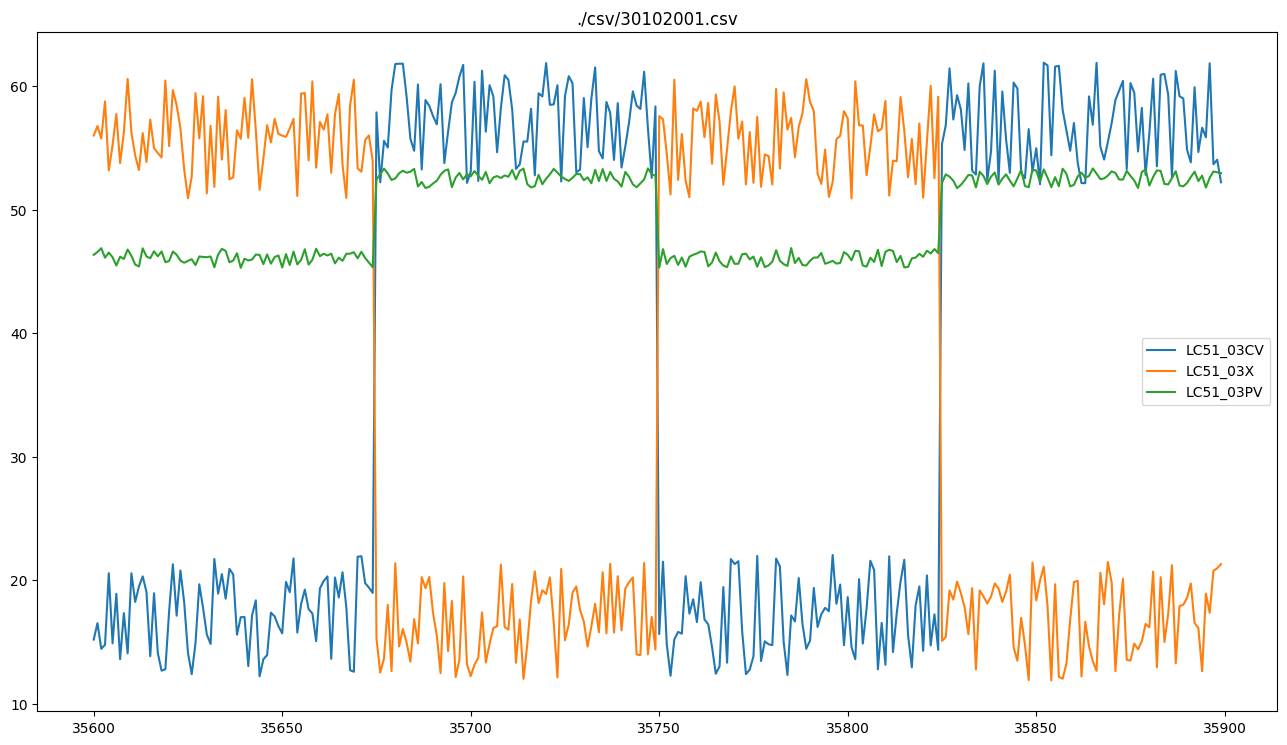

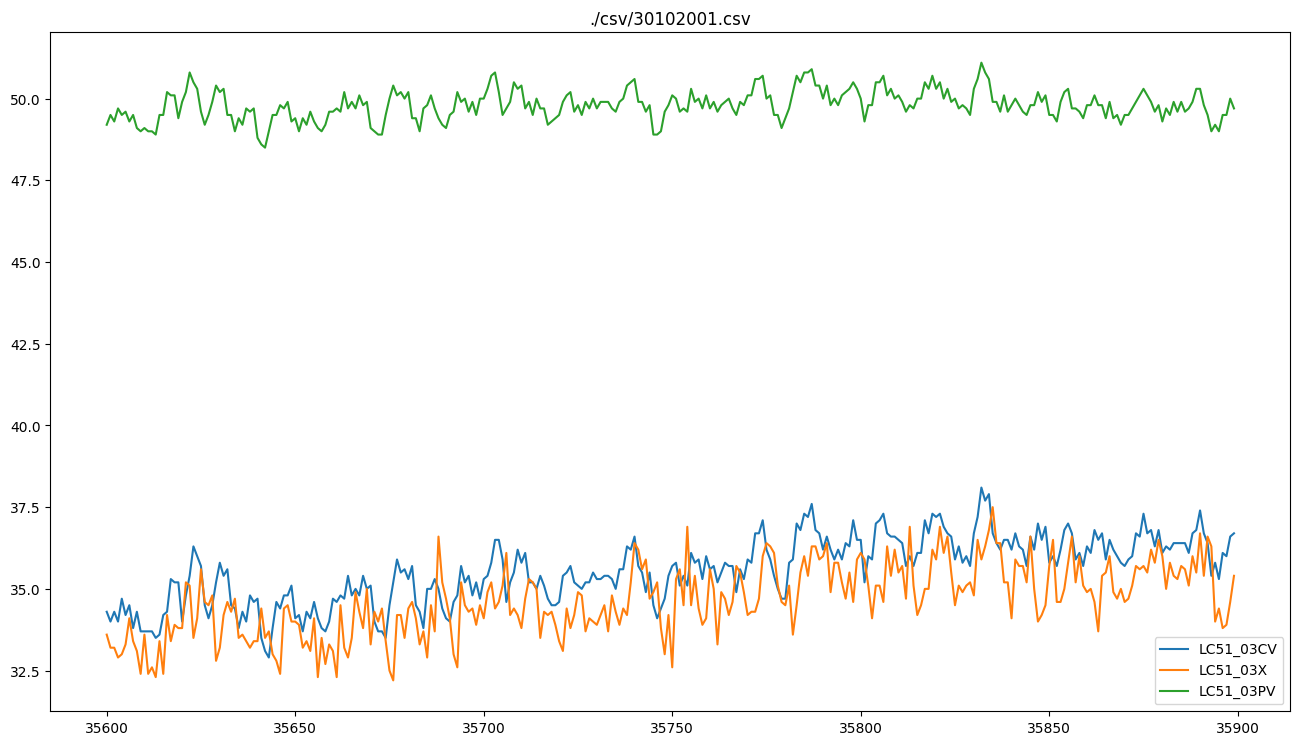

In [4]:
# fault in 09112001.csv
file = "./csv/30102001.csv"
start, end = 5500, 5800
col_lst = ["LC51_03CV", "LC51_03X", "LC51_03PV"]
df = pd.read_csv(file)
times = [
    [4300, 4600],
    [7200, 7500],
    [12000, 12300],
    [23100, 23400],
    [35600, 35900]
]
data = df.copy()
data["anomaly_label_user"] = data["anomaly_label"]
for time in times:
    data = generate_pattern(data, col_lst, time[0], time[1], pattern = 1)
    data["anomaly_label_user"][time[0]: time[1]] = 1
    analysis(data, time[0], time[1], col_lst)
    analysis(df, time[0], time[1], col_lst)
# data.to_csv("./csv/30102001_user_anomaly.csv", index = False)

In [50]:
data

,P51_05,P51_06,T51_01,F51_01,LC51_03CV,LC51_03X,LC51_03PV,TC51_05,T51_08,D51_01,...,F74_00,LC74_20CV,LC74_20X,LC74_20PV,F74_30,P74_30,T74_30,fault_label,anomaly_label,anomaly_label_user
0,665.7,342.9,96.7,350.4,35.5,34.8,48.8,128.9,134.0,12.9,...,24.1,62.9,54.0,49.1,14.1,2474.2,398.8,0,0,0
1,654.2,344.1,96.8,350.9,34.6,34.7,49.2,128.9,134.0,12.9,...,22.6,55.9,56.8,50.7,14.1,2473.3,398.9,0,0,0
2,652.3,347.5,96.8,357.4,35.0,34.3,49.2,128.9,134.0,12.9,...,20.6,54.9,61.1,50.5,14.2,2474.2,399.0,0,0,0
3,651.3,349.9,96.7,359.0,35.3,34.3,49.8,128.9,134.0,12.9,...,22.8,57.1,57.6,49.7,14.0,2474.2,398.8,0,0,0
4,654.2,347.3,96.8,359.6,36.1,33.4,50.0,128.9,134.0,12.9,...,21.6,61.2,56.3,51.1,14.0,2475.2,398.8,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,762.9,253.2,96.1,266.8,49.4,48.1,48.6,126.0,129.3,12.7,...,2.1,91.5,87.1,49.2,7.9,2463.5,377.3,0,0,0
86396,763.4,253.2,96.1,266.7,49.4,48.7,48.7,126.0,129.4,12.7,...,1.2,90.2,89.1,48.4,8.0,2462.5,377.1,0,0,0
86397,758.2,255.9,96.1,267.0,49.7,48.9,49.0,126.0,129.4,12.7,...,1.3,84.3,90.8,49.2,7.8,2462.5,377.1,0,0,0
86398,760.9,251.8,96.1,267.2,50.0,49.5,49.2,126.0,129.4,12.7,...,2.7,82.3,89.0,48.9,7.7,2462.5,377.1,0,0,0
